In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pandas as pd
from scipy.constants import c
from scipy.integrate import quad

#Nested sampling package
import ultranest
import corner

# I. Import data

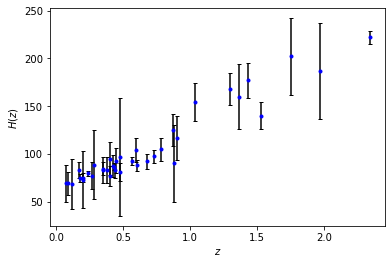

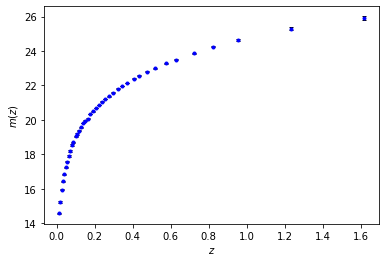

In [2]:
# Import Hubble H(z) data

hubble_data = pd.read_csv('hubble_data.csv', header=0)

z_H = np.array(hubble_data['z'])
H = np.array(hubble_data['H'])
dH = np.array(hubble_data['dH'])

plt.figure()
plt.errorbar(z_H, H, yerr=dH, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.ylabel(r'$H(z)$')
plt.xlabel(r'$z$')
plt.show()

# Import apparent magnitude m(z) data
m_data = pd.read_csv('m_data.txt', sep = ' ', header = 0)
m_sys_unc = pd.read_csv('m_sys_unc.txt', sep = ' ', header = 0)
m_sys_unc = np.array(m_sys_unc['40']).reshape(40, 40)

tot = m_sys_unc + np.diag(m_data['dmb']**2)

z_m = np.array(m_data['zcmb'])
m = np.array(m_data['mb'])
dm = np.sqrt(np.diag(tot))

plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.show()

# Combine redshifts for likelihood computation later
combined_z = []
combined_z.append(z_H)
combined_z.append(z_m)

# Combine data
combined_data = []
combined_data.append(H)
combined_data.append(m)

# Combine uncertainties
combined_unc = []
combined_unc.append(dH)
combined_unc.append(dm)

# II. Define models

In [3]:
'Define Inverse Monomial model'
def InverseMonomial(z, params):
    H0 = params[0] 
    B = params[1]
    
    return H0*np.sqrt((1/(1+B*z))*(1+z)**3)

'Define Exponential Model'
def Exponential(z, params):
    H0 = params[0] 
    B = params[1]
    
    return H0*np.sqrt(np.exp(B*((1/(1+z))-1))*(1+z)**3)

'Define apparent magnitude function'
def ApparentMagnitude(z, Hubble, params):
    
    def integrand_dl(z, Hubble, params):
    #integrand of luminosity distance formula
        return params[0]/Hubble(z, params)

    def dl(z, Hubble, params):
    #dimensionless luminosity distance at redshift z (input array)
        rz_array = np.zeros(len(z))  
        for i in np.arange(len(z)):
            rz_each = quad( integrand_dl, 0, z[i],
                        args = (Hubble, params) )[0]
            rz_array[i] = rz_each
            
        return (1+z)*rz_array
    
    return 5*np.log10((c*100/params[0])*dl(z, Hubble, params)) - 19.25

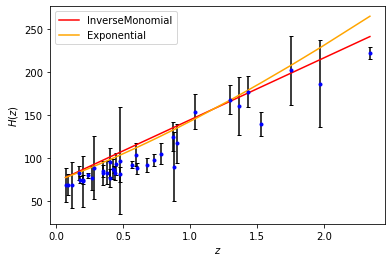

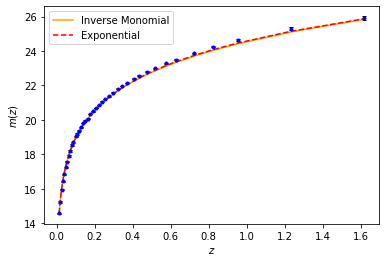

In [4]:
params_InverseMonomial = [72.21, 1]
params_Exponential = [73.37, 1.5]

plt.figure()
plt.errorbar(z_H, H, yerr=dH, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.plot(z_H, InverseMonomial(z_H, params_InverseMonomial), color='red', label='InverseMonomial')
plt.plot(z_H, Exponential(z_H, params_Exponential), color='orange', label='Exponential')
plt.legend(loc='best')
plt.ylabel(r'$H(z)$')
plt.xlabel(r'$z$')
plt.show()

plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.plot(z_m, ApparentMagnitude(z_m, InverseMonomial, params_InverseMonomial), color='orange', label='Inverse Monomial')
plt.plot(z_m, ApparentMagnitude(z_m, Exponential, params_Exponential), color='red', ls='--', label='Exponential')
plt.legend(loc='best')
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.show()

# III. Nested Sampling: Inverse Monomial

In [5]:
def Prior_InverseMonomial(cube):

    #H0 Prior: [0,100]
    H0_min = 0
    H0_max = 100
    
    #B Prior: [0,4]
    B_min = 0
    B_max = 4
    
    #M Prior: [0,1]
    #M_min = -21
    #M_max = -18
    
    #Extract values
    H0prime = cube[0]
    Bprime = cube[1]
    
    #OLprime = cube[2]
    #Mprime = cube[3]
        
    H0 = H0prime*(H0_max-H0_min) + H0_min
    B = Bprime*(B_max-B_min) + B_min
    #OL = OLprime*(OL_max-OL_min) + OL_min
    #M = Mprime*(M_max-M_min) + M_min
        
    return np.array([H0, B])
    
def LogLikelihood_InverseMonomial(params):
        

    # calculate the model
    hubble_model = InverseMonomial(z_H, params)
    apparent_magnitude_model = ApparentMagnitude(z_m, InverseMonomial, params)
        
    #calculate the likelihood
    residual_H = H - hubble_model
    residual_m = m - apparent_magnitude_model
    sig_H = 1/dH
    sig_m = 1/dm
        
    lnL_H = -0.5*np.sum((residual_H*sig_H)**2)
    lnL_m = -0.5*np.sum((residual_m*sig_m)**2)

    return  lnL_H + lnL_m 

In [6]:
t_i = time()
sampler_InverseMonomial = ultranest.ReactiveNestedSampler(['H0', 'B'], LogLikelihood_InverseMonomial, Prior_InverseMonomial)
result_InverseMonomial = sampler_InverseMonomial.run()
sampler_InverseMonomial.print_results()
t_f = time()

print('Sampling time: {} s'.format(t_f-t_i))


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-53.9003..-53.9003]*| it/evals=5286/7269 eff=76.9544% N=400     0   00 0  
[ultranest] Likelihood function evaluations: 7274
[ultranest]   logZ = -62.5 +- 0.09984
[ultranest] Effective samples strategy satisfied (ESS = 1619.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.27, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -62.516 +- 0.269
  single instance: logZ = -62.516 +- 0.138
  bootstrapped   : logZ = -62.501 +- 0.269
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H0                  72.92 +- 0.31
    B                   1.969 +- 0.078
Sampling time: 66.36491703987122 s


In [7]:
points_InverseMonomial= np.array(result_InverseMonomial["weighted_samples"]["points"])
weights_InverseMonomial= np.array(result_InverseMonomial["weighted_samples"]["weights"])
scaledweights_InverseMonomial = weights_InverseMonomial / weights_InverseMonomial.max()
mask_InverseMonomial = np.random.rand(len(scaledweights_InverseMonomial)) < scaledweights_InverseMonomial

samples_InverseMonomial = points_InverseMonomial[mask_InverseMonomial, :]

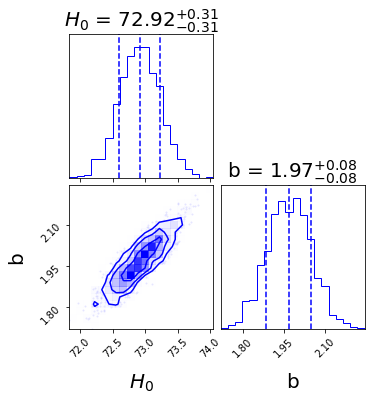

In [8]:
# Open saved samples
def open_samples(file):
    
    chains = pd.read_csv(file)
    nparams = len(chains.columns)
    
    if nparams == 2:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]))).T
    if nparams == 3:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]), np.array(chains.iloc[:, 2]))).T
    if nparams == 4:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]), np.array(chains.iloc[:, 2]), np.array(chains.iloc[:, 3]))).T
    
    return samples

# Extract and compile chains
InverseMonomial_chain_1 = samples_InverseMonomial[:,0] # extract chain of H0 values
InverseMonomial_chain_2 = samples_InverseMonomial[:,1] # extract chain if OM values
#lcdm_chain_3 = samples_LCDM[:,2] # extract chain if OL values
InverseMonomial_samples = np.vstack((InverseMonomial_chain_1, InverseMonomial_chain_2)).T

# Save chains and evidence (do not forget)
np.savetxt('InverseMonomial_chains.csv', InverseMonomial_samples, delimiter=",")
np.savetxt('InverseMonomial_Z.csv', [[result_InverseMonomial['logz'] , result_InverseMonomial['logzerr']]])

# Open saved chains
#samples_open =  open_samples('InverseMonomial_chains_Aug11_9PM.csv')

fig = corner.corner(InverseMonomial_samples, labels=[r"$H_0$", "b"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
fig.savefig('InverseMonomial.pdf')

# IV. Nested Sampling: Exponential Model

In [9]:
def Prior_Exponential(cube):

    #H0 Prior: [0,100]
    H0_min = 0
    H0_max = 100
    
    #B Prior: [0,4]
    B_min = 0
    B_max = 4
    
    #M Prior: [0,1]
    #M_min = -21
    #M_max = -18
    
    #Extract values
    H0prime = cube[0]
    Bprime = cube[1]
    
    #OLprime = cube[2]
    #Mprime = cube[3]
        
    H0 = H0prime*(H0_max-H0_min) + H0_min
    B = Bprime*(B_max-B_min) + B_min
    #OL = OLprime*(OL_max-OL_min) + OL_min
    #M = Mprime*(M_max-M_min) + M_min
        
    return np.array([H0, B])
    
def LogLikelihood_Exponential(params):
        

    # calculate the model
    hubble_model = Exponential(z_H, params)
    apparent_magnitude_model = ApparentMagnitude(z_m, Exponential, params)
        
    #calculate the likelihood
    residual_H = H - hubble_model
    residual_m = m - apparent_magnitude_model
    sig_H = 1/dH
    sig_m = 1/dm
        
    lnL_H = -0.5*np.sum((residual_H*sig_H)**2)
    lnL_m = -0.5*np.sum((residual_m*sig_m)**2)

    return  lnL_H + lnL_m 

In [10]:
t_i = time()
sampler_Exponential = ultranest.ReactiveNestedSampler(['H0', 'B'], LogLikelihood_Exponential, Prior_Exponential)
result_Exponential = sampler_Exponential.run()
sampler_Exponential.print_results()
t_f = time()

print('Sampling time: {} s'.format(t_f-t_i))

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-38.0641..-38.0641]*| it/evals=5399/7350 eff=77.6835% N=400     0   00 0  
[ultranest] Likelihood function evaluations: 7350
[ultranest]   logZ = -46.93 +- 0.09886
[ultranest] Effective samples strategy satisfied (ESS = 1620.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -46.951 +- 0.209
  single instance: logZ = -46.951 +- 0.140
  bootstrapped   : logZ = -46.935 +- 0.209
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H0                  73.32 +- 0.27
    B                   2.118 +- 0.052
Sampling time: 69.25908899307251 s


In [11]:
points_Exponential = np.array(result_Exponential["weighted_samples"]["points"])
weights_Exponential = np.array(result_Exponential["weighted_samples"]["weights"])
scaledweights_Exponential = weights_Exponential/ weights_Exponential.max()
mask_Exponential = np.random.rand(len(scaledweights_Exponential)) < scaledweights_Exponential

samples_Exponential = points_Exponential[mask_Exponential, :]

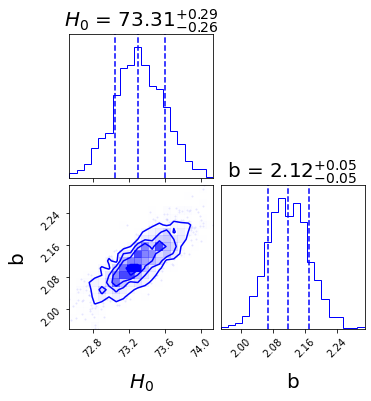

In [12]:
# Open saved samples
def open_samples(file):
    
    chains = pd.read_csv(file)
    nparams = len(chains.columns)
    
    if nparams == 2:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]))).T
    if nparams == 3:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]), np.array(chains.iloc[:, 2]))).T
    if nparams == 4:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]), np.array(chains.iloc[:, 2]), np.array(chains.iloc[:, 3]))).T
    
    return samples

# Extract and compile chains
Exponential_chain_1 = samples_Exponential[:,0] # extract chain of H0 values
Exponential_chain_2 = samples_Exponential[:,1] # extract chain if OM values
#lcdm_chain_3 = samples_LCDM[:,2] # extract chain if OL values
Exponential_samples = np.vstack((Exponential_chain_1, Exponential_chain_2)).T

# Save chains and evidence (do not forget)
np.savetxt('Exponential_chains.csv', Exponential_samples, delimiter=",")
np.savetxt('Exponential_Z.csv', [[result_Exponential['logz'] , result_Exponential['logzerr']]])

# Open saved chains
#samples_open =  open_samples('InverseMonomial_chains_Aug11_9PM.csv')

fig = corner.corner(Exponential_samples, labels=[r"$H_0$", "b"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
fig.savefig('Exponential.pdf')